In [1]:
import os
import requests
import numpy as np
import tensorflow.keras as keras
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, cohen_kappa_score
import matplotlib.pyplot as plt

from scripts.tools import generate_train_test, confusion_matrix, roc_plot, normalize_ts, scale_input_data

%matplotlib inline

tf.random.set_seed(1234)
np.random.seed(4321)

# Download data sets

In [2]:
url_tsc = 'https://osf.io/4d2yt/download'
url_mlp = 'https://osf.io/4fcrw/download'

try: 
    with open('data_set/mms1_samp_4dot5s_win_3min_pad_wrap.h5', 'xb') as r:
        html_tsc = requests.get(url_tsc)
        r.write(html_tsc.content)
except FileExistsError:
    print('TSC file has not been downloaded, file already exists')

try:
    with open('data_set/mlp_mms1_samp_4dot5s.h5', 'xb') as r:
        html_mlp = requests.get(url_mlp)
        r.write(html_mlp.content)
except FileExistsError:
    print('MLP file has not been downloaded, file already exists')

TSC file has not been downloaded, file already exists
MLP file has not been downloaded, file already exists


# FCN

## Read the model and input data

In [3]:
# Import information on data and training
ml_method = 'tsc' # tsc, mlp
data_version = 'mms1_samp_4dot5s_win_3min_pad_wrap' 
data_process = 'no_flux_shuffle_znorm' 
classifier_name = 'fcn'
period = '2016_2018'

x_train, y_train, x_test, y_test, x_val, y_val = generate_train_test(
    ml_method, data_version, data_process, period)

if ml_method == 'tsc':
    model_path = os.path.join('trained_model', 'fcn','best_model.hdf5')
    model = keras.models.load_model(model_path)
else:
    raise ValueError('Not implemented')
    
association = {0:'sw', 1: 'fs', 2:'bs', 3:'msh', 4:'mp', 5:'bl', 6:'msp', 7:'ps', 8:'psbl', 9:'lobe'}

## Confusion matrix

In [4]:
y_score = model.predict(x_test)
y_score = y_score / np.sum(y_score, axis=1).reshape((-1,1))

y_pred = np.argmax(y_score,axis=1)

conf_matrix, percentage = confusion_matrix(y_pred, y_test, association=association)

print(cohen_kappa_score(y_test, y_pred))

display(conf_matrix)

0.8799929747530728


True,sw,fs,bs,msh,mp,bl,msp,ps,psbl,lobe
Predicted,,,,,,,,,,
sw,493,53,8,0,2,1,2,0,0,0
fs,42,1140,40,0,0,0,0,0,0,0
bs,2,12,450,54,8,1,0,0,0,0
msh,0,1,52,982,41,5,0,0,0,0
mp,0,0,10,37,801,92,5,3,2,1
bl,0,0,1,4,78,933,49,39,10,0
msp,0,0,0,0,10,32,1101,0,0,0
ps,0,0,0,0,5,38,5,803,54,1
psbl,0,0,0,0,7,13,0,59,572,15


## Classification report: Precision, recall, f1-score

In [5]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90       537
         1.0       0.93      0.95      0.94      1206
         2.0       0.85      0.80      0.83       561
         3.0       0.91      0.91      0.91      1077
         4.0       0.84      0.84      0.84       952
         5.0       0.84      0.84      0.84      1115
         6.0       0.96      0.95      0.96      1162
         7.0       0.89      0.89      0.89       905
         8.0       0.86      0.87      0.87       654
         9.0       0.95      0.95      0.95       371

    accuracy                           0.89      8540
   macro avg       0.89      0.89      0.89      8540
weighted avg       0.89      0.89      0.89      8540



## ROC

n_classes 10
AUC macro average :0.9927366208431044
AUC micro average :0.9937888827034891


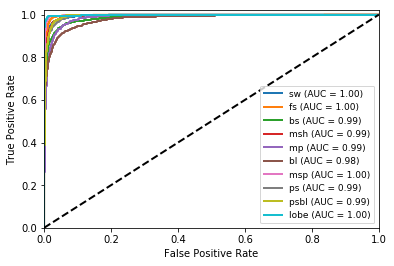

In [6]:
fig = roc_plot(y_score, y_test, association=association)
plt.show()

# MLP

## Read the model and input data

In [7]:
# Import information on data and training
ml_method = 'mlp' # tsc, mlp
data_version = 'mms1_samp_4dot5s' 
data_process = 'no_flux_shuffle' 
classifier_name = 'mlp'
period = '2016_2018'

x_train, y_train, x_test, y_test, x_val, y_val = generate_train_test(
    ml_method, data_version, data_process, period)

if ml_method == 'mlp':
    x_train, x_test = scale_input_data(x_train, x_test)
    model_path = os.path.join('trained_model', 'mlp', 'trained_model.hdf5')
    model = keras.models.load_model(model_path)
else:
    raise ValueError('Not implemented')

## Confusion matrix

In [8]:
print(x_test.shape)

y_score = model.predict(x_test)
y_score = y_score / np.sum(y_score, axis=1).reshape((-1,1))

y_pred = np.argmax(y_score,axis=1)

conf_matrix, percentage = confusion_matrix(y_pred, y_test, association=association)

print(cohen_kappa_score(y_test, y_pred))

display(conf_matrix)

(332784, 12)
0.8041632196248358


True,sw,fs,bs,msh,mp,bl,msp,ps,psbl,lobe
Predicted,,,,,,,,,,
sw,18329,2213,689,23,6,8,350,0,0,0
fs,2735,44491,4515,43,158,59,22,5,0,0
bs,174,711,8433,2497,2210,221,9,15,0,2
msh,22,67,5416,37018,3430,329,2,0,0,5
mp,15,132,2040,1873,23727,5190,425,253,141,29
bl,0,0,13,24,2106,31637,1896,1242,220,54
msp,0,0,6,0,701,2930,43454,39,27,0
ps,2,5,34,2,677,3184,195,30859,2206,103
psbl,0,0,9,1,352,715,0,2974,22969,953


## Classification report

In [9]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.85      0.86      0.85     21277
         1.0       0.86      0.93      0.89     47619
         2.0       0.59      0.40      0.48     21156
         3.0       0.80      0.89      0.84     41481
         4.0       0.70      0.71      0.71     33369
         5.0       0.85      0.71      0.78     44303
         6.0       0.92      0.94      0.93     46353
         7.0       0.83      0.87      0.85     35432
         8.0       0.82      0.86      0.84     26645
         9.0       0.92      0.92      0.92     15149

    accuracy                           0.83    332784
   macro avg       0.81      0.81      0.81    332784
weighted avg       0.82      0.83      0.82    332784



## ROC curve

n_classes 10
AUC macro average :0.9822571094812447
AUC micro average :0.9870615505346487


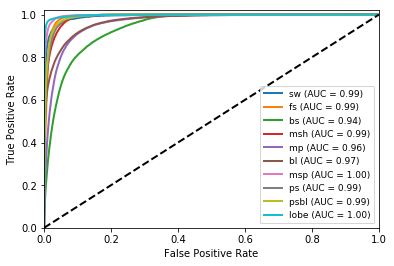

In [10]:
fig = roc_plot(y_score, y_test, association=association)
plt.show()